First we Import the necessary modules:

In [1]:
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot
import itertools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")

import dask.dataframe as dsk
import folium

from sklearn.metrics import mean_squared_error as mse

<h3>1. Importing data and quick Exploration:

In [2]:
data_5m = pd.read_csv("Data/train.csv",nrows = 10000000)
data_5m.shape

(10000000, 8)

In [3]:
data_5m.shape[0] # There might be more than one rows with same index due to how dask structuring the chunk data.

10000000

In [4]:
data_5m.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
#Checking datatypes
data_5m.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [6]:
data_5m.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+07,1.000000e+07,1.000000e+07,9.999931e+06,9.999931e+06,1.000000e+07
mean,1.133854e+01,-7.250775e+01,3.991934e+01,-7.250897e+01,3.991913e+01,1.684793e+00
std,9.799930e+00,1.299421e+01,9.322539e+00,1.287532e+01,9.237280e+00,1.323423e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,3.457626e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


From the above description , we see:<br>
1. There are negative fare amount in the data sample.I am removing those datapoints from the data sample in the removing outlier section.<br>
2. Average fare amount is around 11.3 dollars and has a std of 9.7 dollars.

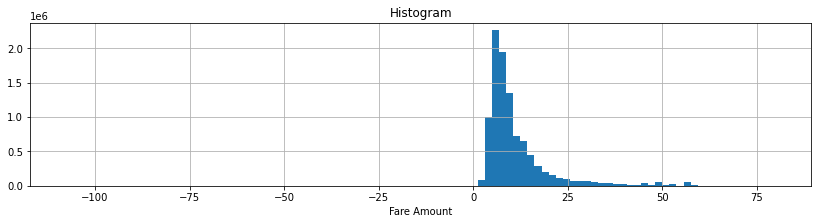

In [7]:
# plotting histogram of fare
data_5m[data_5m.fare_amount<80].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('Fare Amount')
plt.title('Histogram');

Maximum trips have fare amount lower than 20 dollars

<h3> 2. Data Cleaning and Feature Extraction </h3>

<b>Checking columns with null values:

In [8]:
print(data_5m.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    69
dropoff_latitude     69
passenger_count       0
dtype: int64


<b>Removing the rows with null values

In [9]:
data_5m = data_5m[data_5m['dropoff_longitude'].notnull()]
data_5m = data_5m[data_5m['dropoff_latitude'].notnull()]

<b>Date Time Handling:

In [10]:
data_5m['pickup_datetime'] = data_5m['pickup_datetime'].str.replace(" UTC","")
data_5m['pickup_datetime'] = pd.to_datetime(data_5m['pickup_datetime'])

<b>Creating separate features for Year, Month , Day and some other special features

In [11]:
mapping = {1:"01-JAN",2:"02-FEB",3:"03-MAR",4:"04-APR",5:"05-MAY",6:"06-JUN",7:"07-JUL",
           8:"08-AUG",9:"09-SEP",10:"10-OCT",11:"11-NOV",12:"12-DEC"}

data_5m["year"]  = data_5m["pickup_datetime"].dt.year
data_5m["month"] = data_5m["pickup_datetime"].dt.month
data_5m["day"] = data_5m["pickup_datetime"].dt.day
data_5m["month_name"] = data_5m["month"].map(mapping)

#merge year month
data_5m["month_year"] = data_5m["year"].astype(str) + " - " + data_5m["month_name"]
#extract week day 
data_5m["week_day"] = data_5m["pickup_datetime"].dt.strftime("%A")
#extract hour
data_5m["hour"] = data_5m["pickup_datetime"].dt.hour 
#Sorting the data according to date time
data_5m = data_5m.sort_values(by = "pickup_datetime",ascending = False)

<b>Analysing outliers:

Fare Amount:

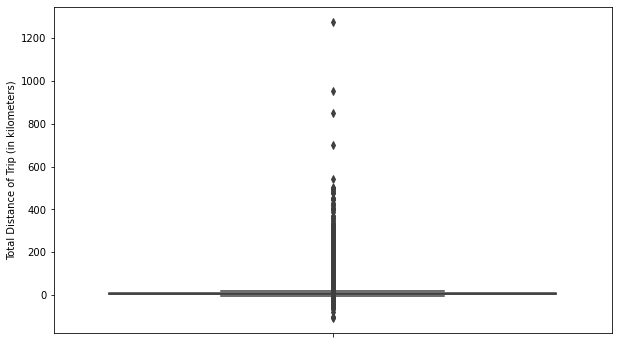

In [12]:
plt.figure(figsize = (10,6))
sns.boxplot("fare_amount", data = data_5m, orient = "v")
plt.ylabel("Total Distance of Trip (in kilometers)")
plt.show()

In [13]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in np.linspace(0,1,11):
    print("{} percentile value is {} dollars".format(np.round(i,2),np.round(data_5m['fare_amount'].quantile(i),2)))

0.0 percentile value is -107.75 dollars
0.1 percentile value is 4.5 dollars
0.2 percentile value is 5.5 dollars
0.3 percentile value is 6.5 dollars
0.4 percentile value is 7.3 dollars
0.5 percentile value is 8.5 dollars
0.6 percentile value is 9.7 dollars
0.7 percentile value is 11.5 dollars
0.8 percentile value is 14.1 dollars
0.9 percentile value is 20.5 dollars
1.0 percentile value is 1273.31 dollars


In [14]:
for i in np.linspace(0.9,1,11):
    print("{} percentile value is {} min".format(np.round(i,2),np.round(data_5m['fare_amount'].quantile(i),2)))

0.9 percentile value is 20.5 min
0.91 percentile value is 21.7 min
0.92 percentile value is 23.3 min
0.93 percentile value is 25.3 min
0.94 percentile value is 27.7 min
0.95 percentile value is 30.33 min
0.96 percentile value is 33.5 min
0.97 percentile value is 38.5 min
0.98 percentile value is 46.83 min
0.99 percentile value is 53.0 min
1.0 percentile value is 1273.31 min


In [15]:
#Removing the outliers
data_5m = data_5m[data_5m['fare_amount'] < data_5m['fare_amount'].quantile(0.9999)]

In [16]:
#dropping rows with fareamount  less than 0
data_5m = data_5m[ (data_5m["fare_amount"] >= 0 ) ]

In [17]:
#Log of fare amount
data_5m['fare_log'] = np.log(data_5m['fare_amount'])
data_5m = data_5m[data_5m.fare_log > 0]

Passenger counts and map coordinates that occur very rare:

In [18]:
#dropping rows with passengers greater than 6 and equals 0
data_5m = data_5m[(data_5m["passenger_count"] > 0 ) & (data_5m["passenger_count"] < 7) ]

#Dropping rarely occuring values of pickup and dropoff coordinates
coordinates = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for c in coordinates:
    data_5m = data_5m[(data_5m[c] > data_5m[c].quantile(0.001)) & (data_5m[c] < data_5m[c].quantile(0.999))]

<b>Creating new feature : Distance of trips</b>:<br>

<b> Haversine Distance</b> : The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes(wikipedia) <br>

It can be calculated using the below formula: <br>
* lon_dist = lon2 - lon1 
* lat_dist  = lat2 - lat1 
* a = (sin(lat_dist/2))^2 + cos(lat1) * cos(lat2) * (sin(lon_dist/2))^2 
* c = 2 * atan2( sqrt(a), sqrt(1-a) ) 
* d = R * c (where R is the radius of the Earth)<br>


In [19]:
def haversine_vectorize(data):
    lat_1, lon_1, lat_2, lon_2 = map(np.radians, [data["pickup_latitude"], data["pickup_longitude"], data["dropoff_latitude"]
                                              , data["dropoff_longitude"]])
    lon = lon_2 - lon_1
    lat = lat_2 - lat_1
    haver_formula = np.sin(lat/2.0)**2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(lon/2.0)**2
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km
data_5m['trip_distance'] = haversine_vectorize(data_5m)

In [20]:
#create new variable log of distance
data_5m["log_trip_distance"] = np.log(data_5m["trip_distance"])

<b>Analysis of trip distance for outliers:

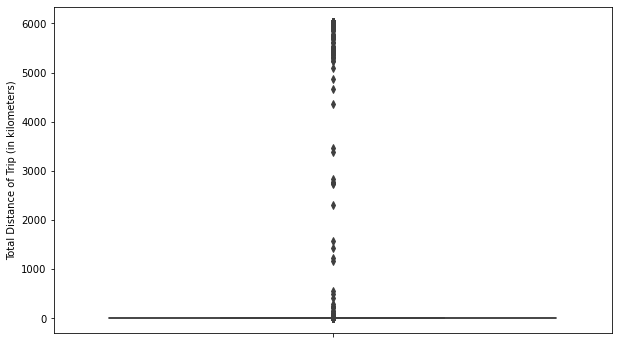

In [21]:
plt.figure(figsize = (10,6))
sns.boxplot("trip_distance", data = data_5m, orient = "v")
plt.ylabel("Total Distance of Trip (in kilometers)")
plt.show()

In [22]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in np.linspace(0,1,11):
    print("{} percentile value is {} min".format(np.round(i,2),data_5m['trip_distance'].quantile(i)))

0.0 percentile value is 0.0 min
0.1 percentile value is 0.7865929091413745 min
0.2 percentile value is 1.1047912144313636 min
0.3 percentile value is 1.4087277799414735 min
0.4 percentile value is 1.7485217489992122 min
0.5 percentile value is 2.1472169578831366 min
0.6 percentile value is 2.656856670030432 min
0.7 percentile value is 3.3781928588186414 min
0.8 percentile value is 4.538791336271721 min
0.9 percentile value is 6.906880648308986 min
1.0 percentile value is 6030.758707550739 min


In [23]:
for i in np.linspace(0.9,1,11):
    print("{} percentile value is {} min".format(np.round(i,2),data_5m['trip_distance'].quantile(i)))

0.9 percentile value is 6.906880648308986 min
0.91 percentile value is 7.349012430316144 min
0.92 percentile value is 7.889994056353316 min
0.93 percentile value is 8.536251427231434 min
0.94 percentile value is 9.17035991721401 min
0.95 percentile value is 9.801458423149121 min
0.96 percentile value is 10.651784814300374 min
0.97 percentile value is 12.371869112009119 min
0.98 percentile value is 15.63708674915179 min
0.99 percentile value is 20.22536998647729 min
1.0 percentile value is 6030.758707550739 min


In [24]:
data_5m = data_5m[data_5m['trip_distance'] < data_5m['trip_distance'].quantile(0.9999)]

<b> Analysing Pickup and Dropoff Location Data </b><br>

Source: (https://www.flickr.com/places/info/2459115):
New York is bounded by the location coordinates(latitude, longitude) - (40.5774, -74.15) & (40.9176,-73.7004).Hence any datapoints with coordinates(including both pickups and drop-offs) that are outside the bounding coordinates of newyork city are needed to be dropped as we are only concerned with trips which happened within New York.


Outliers : Visualizing Pickups outside Newyork

In [ ]:
outside_NYC = data_5m[((data_5m.pickup_latitude <= 40.5774) | (data_5m.pickup_longitude <= -74.15) |
                       (data_5m.pickup_latitude >= 40.9176) | (data_5m.pickup_longitude >= -73.7004))]

map_boundary = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")
pickups_outside = outside_NYC.head(20000)

for i,row in pickups_outside.iterrows():
    if row["pickup_latitude"] != 0:
        folium.Marker([row["pickup_latitude"], row["pickup_longitude"]]).add_to(map_boundary)
map_boundary

Outliers : Visualizing dropoffs outside neywork

In [ ]:
outside_NYC = data_5m[((data_5m.dropoff_latitude <= 40.5774) | (data_5m.dropoff_longitude <= -74.15) \
                          | (data_5m.dropoff_latitude >= 40.9176) | (data_5m.dropoff_longitude >= -73.7004))]

map_boundary = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")
dropoff_outside = outside_NYC.head(20000)

for i,row in dropoff_outside.iterrows():
    if row["dropoff_latitude"] != 0:
        folium.Marker([row["dropoff_latitude"], row["dropoff_longitude"]]).add_to(map_boundary)
map_boundary

Removing all pickup and dropoffs that were outside Newyork city:

In [25]:
data_5m = data_5m[(((data_5m.pickup_latitude >= 40.5774) & (data_5m.pickup_latitude <= 40.9176)) & \
                   ((data_5m.pickup_longitude >= -74.15) & (data_5m.pickup_longitude <= -73.7004)))]

data_5m = data_5m[(((data_5m.dropoff_latitude >= 40.5774) & (data_5m.dropoff_latitude <= 40.9176)) & 
                   ((data_5m.dropoff_longitude >= -74.15) &(data_5m.dropoff_longitude <= -73.7004)))]

<b>How much Data was lost by removal of outliers and missing values? </b><br>

We show it with the help of a pie diagram.


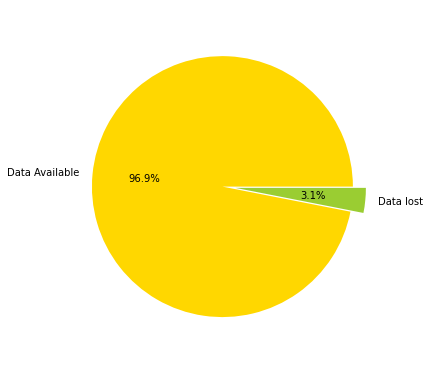

In [26]:
sizes = [data_5m.shape[0],10000000 - data_5m.shape[0]]
explode = (0.1, 0)
labels = 'Data Available', 'Data lost'
colors = ['gold', 'yellowgreen']
fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%')
plt.axis('equal')
plt.show()

About 3%(300000) datapoints from a data sample of 10000000 instances are lost which is quite reasonable

<b>General Statistical summary of Features:

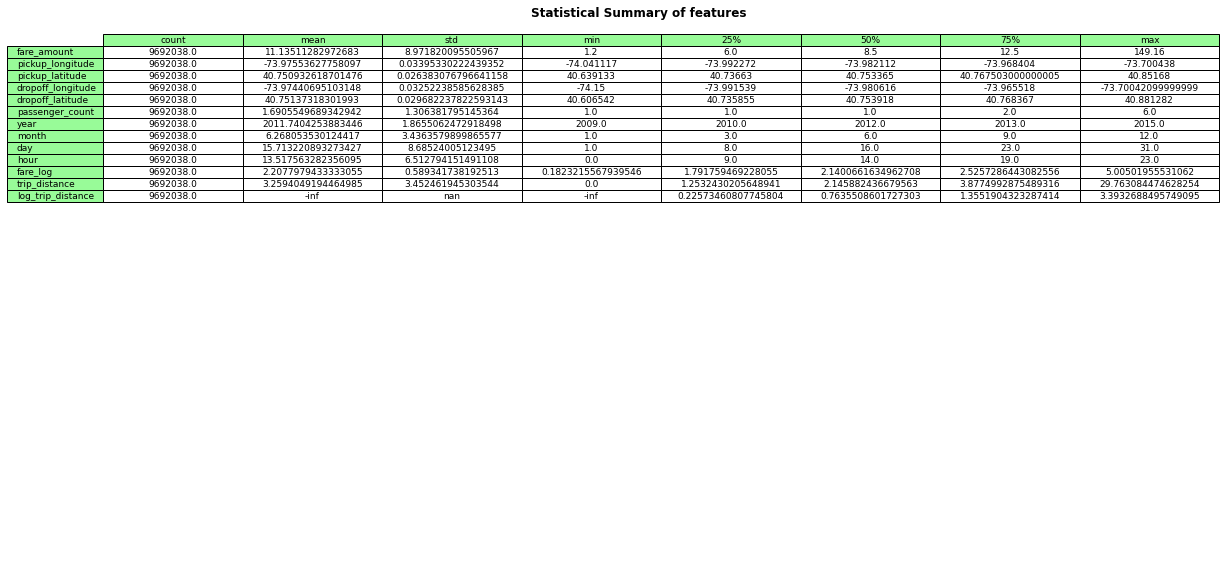

In [27]:
stats1 = data_5m.describe().reset_index()

list_data = []
for i in stats1.columns:
    if(i != 'index'):
         list_data.append(list(stats1[i]))
            
fig, ax = plt.subplots(figsize=(20,10))
fig1.subplots_adjust(8,5,10,10)
ax.set_axis_off() 
table = ax.table( cellText = list_data,  rowLabels = stats1.columns.tolist()[1:],  colLabels = stats1['index'].values, 
    rowColours =["palegreen"] * 13,  colColours =["palegreen"] * 8, cellLoc ='center',  loc ='upper left')         
  
ax.set_title('Statistical Summary of features', fontweight ="bold")   
plt.show() 

<b> Distribution of various numerical features in Data

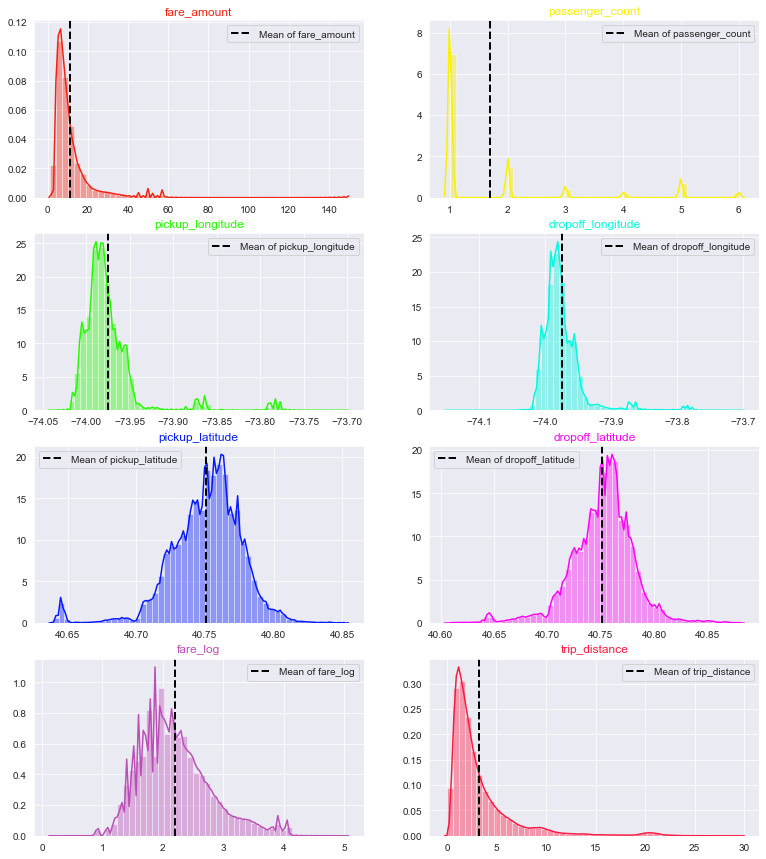

In [30]:
columns = ['fare_amount','passenger_count', 'pickup_longitude', 'dropoff_longitude','pickup_latitude', 'dropoff_latitude','fare_log','trip_distance']

length = len(columns)
color_codes = ["#F32211" ,"#F9F103","#26F903","#03F9E0","#051AFC","#FC05F4","#BB4FB7" , "#FD1942" ]

sns.set_style("darkgrid")
plt.figure(figsize = (13,15))
for i,j,k in itertools.zip_longest(columns,range(length),color_codes) :
    plt.subplot(length/2,length/4,j+1)
    sns.distplot(data_5m[i],color = k)
    plt.axvline(data_5m[i].mean(),linewidth  = 2 ,linestyle = "dashed",color = "k" ,label = "Mean of "+i)
    plt.legend(loc = "best")
    plt.title(i,color = k)
    plt.xlabel("")

<b> Scatter Plot between haversine distance and fare amount

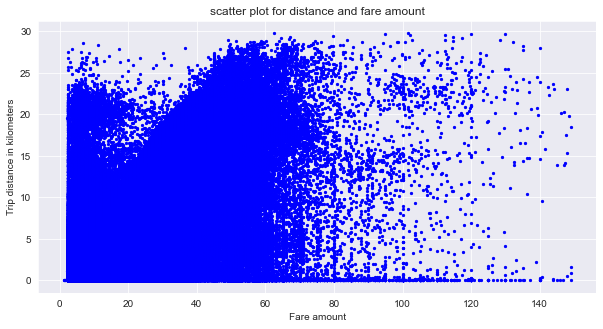

In [31]:
plt.figure(figsize = (10,5))

plt.scatter(data_5m["fare_amount"],data_5m["trip_distance"],s = 5,linewidths=1, c = "b")
plt.ylabel("Trip distance in kilometers")
plt.xlabel("Fare amount")
plt.title("scatter plot for distance and fare amount")
plt.show()

<b> Scatter Plot between  fare amount and log trip distance

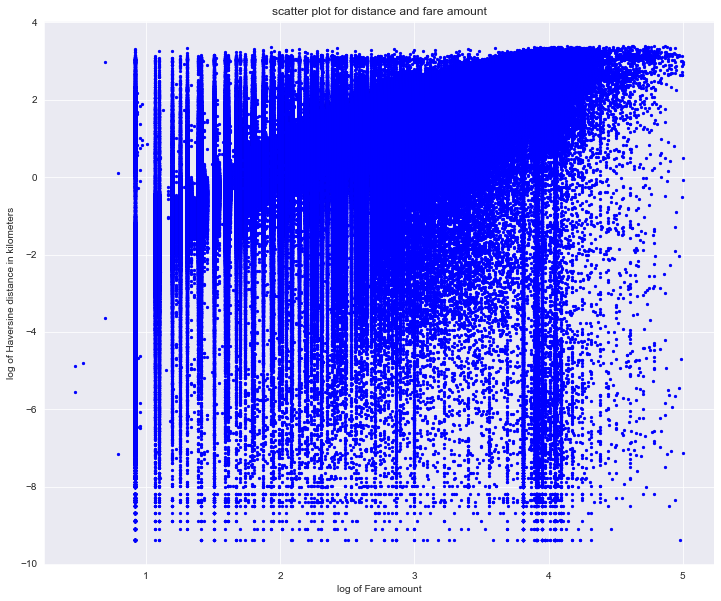

In [32]:
plt.figure(figsize = (12,10))
plt.scatter(data_5m["fare_log"],data_5m["log_trip_distance"],s = 5,linewidths=1, c = "b")
plt.ylabel("log of Haversine distance in kilometers")
plt.xlabel("log of Fare amount")
plt.title("scatter plot for distance and fare amount")
plt.show()

<h3>3. Time Series Data Exploration and Selection </h3>

<b> Yearly count of total trips, total fare amount, total trip distance and total no of passengers 

<function matplotlib.pyplot.show(*args, **kw)>

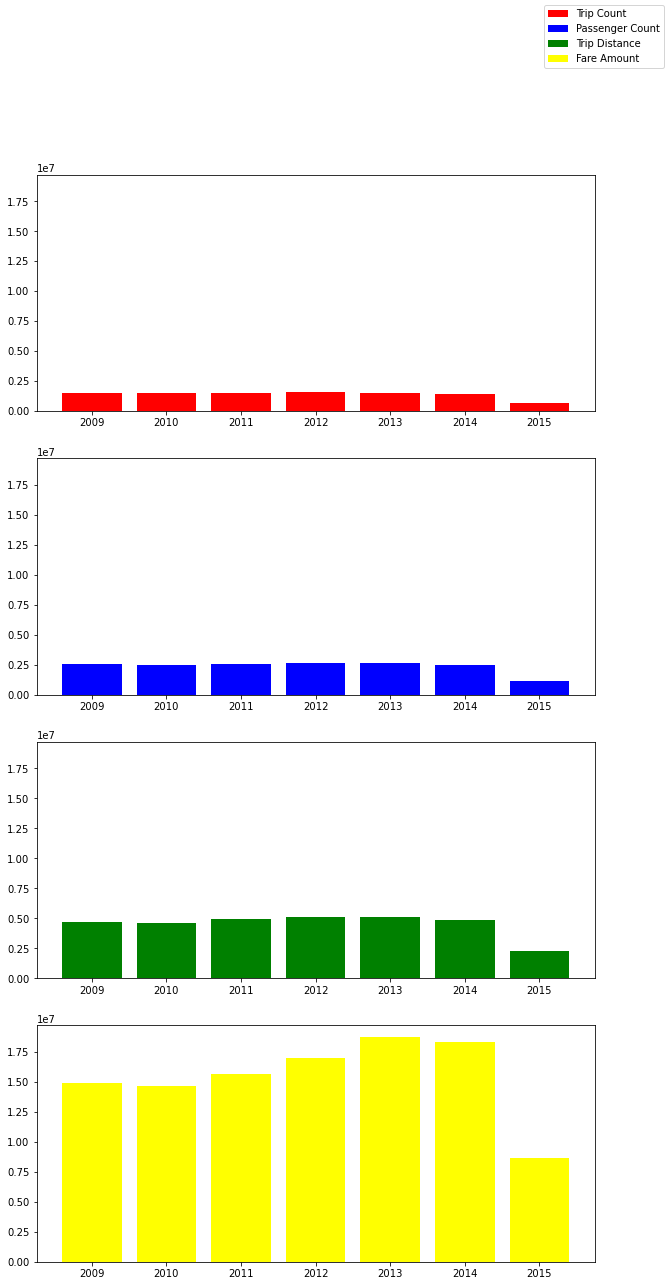

In [58]:
yearwise_stats  = data_5m.groupby("year").agg({"key":"count","fare_amount":"sum","passenger_count":"sum",
                                               "trip_distance" : "sum"}).reset_index()\
                                               .rename(columns = {"key" : "trip_count"})

f, ax = plt.subplots(4,1, sharey='col',figsize=(10,20))
#plotting trips ,passengers and fare amount by year

ax[0].bar(yearwise_stats["year"],yearwise_stats["trip_count"],color = 'red',label = 'Trip Count')

ax[1].bar(yearwise_stats["year"],yearwise_stats["passenger_count"],color = 'blue',label='Passenger Count')

ax[2].bar(yearwise_stats["year"],yearwise_stats["trip_distance"],color = 'green',label = 'Trip Distance')

ax[3].bar(yearwise_stats["year"],yearwise_stats["fare_amount"],color = 'yellow',label = 'Fare Amount')
f.legend(loc="upper right")
plt.show

<h3>Trend in Trips:</h3>
    
Monthly:

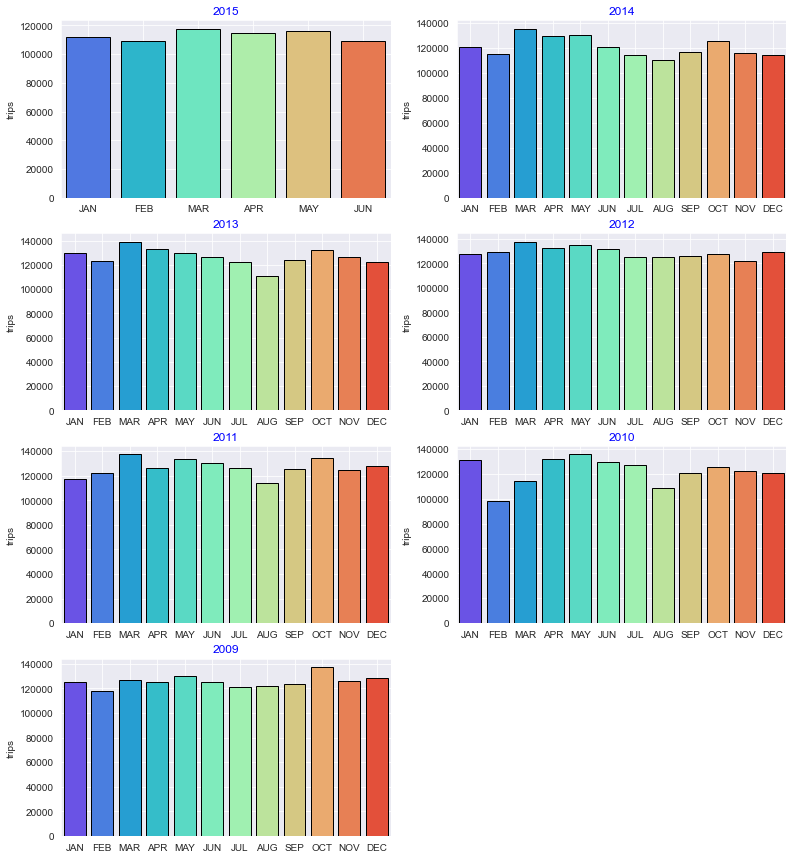

In [34]:
years = [i for i in data_5m["year"].unique().tolist()]
data = data_5m[data_5m["year"].isin(years)]

plt.figure(figsize = (13,15))
for i,j in itertools.zip_longest(years,range(len(years))) :
    plt.subplot(4,2,j+1)
    trip_counts_mn = data[data["year"] == i]["month_name"].value_counts()
    trip_counts_mn.sort_index(inplace = True)
    trip_counts_mn = trip_counts_mn.reset_index()
    trip_counts_mn['index'] = trip_counts_mn['index'].apply(lambda x: str(x).split('-')[1])
    sns.barplot(trip_counts_mn['index'],trip_counts_mn['month_name'],palette = "rainbow",linewidth = 1,edgecolor = "k"*data["month_name"].nunique() )
    plt.title(i,color = "b",fontsize = 12)
    plt.grid(True)
    plt.xlabel("")
    plt.ylabel("trips")

In [60]:
years = [i for i in data_5m["year"].unique().tolist()]
data = data_5m[data_5m["year"].isin(years)]

WeekDays:

In [61]:
def plot_day_trend(year) :
    day_count = data[data["year"] == year]["week_day"].value_counts().reset_index()
    day_count.columns = ["day","count"]
    day_count["order"]  = day_count["day"].replace({"Sunday" :1,'Monday' : 2, 'Tuesday': 3,'Wednesday':4,'Thursday' :5, 'Friday':6,
                                                    'Saturday':7})
    day_count = day_count.sort_values(by = "order",ascending  = True)
    tracer = go.Bar(x = day_count["day"],y = day_count["count"],name = year,marker = dict(line = dict(width =1)))
    return tracer

#layout
layout = go.Layout(dict(title = "Trend in trips  by weekdays",xaxis = dict(title = "weekday"),yaxis = dict(title = "count"),))

t  = plot_day_trend(2009)
t1 = plot_day_trend(2010)
t2 = plot_day_trend(2011)
t3 = plot_day_trend(2012)
t4 = plot_day_trend(2013)
t5 = plot_day_trend(2014)

data = [t,t1,t2,t3,t4,t5]
py.iplot(go.Figure(data = data,layout=layout))

<img src='newplot.png'>

Hour of the day:

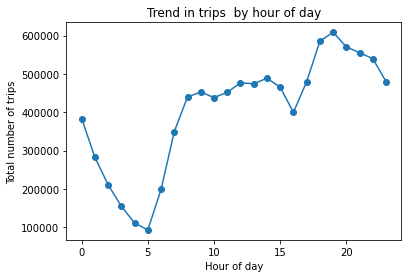

In [63]:
trips_hour = data_5m["hour"].value_counts().reset_index()
trips_hour.columns = ["hour","count"]
trips_hour = trips_hour.sort_values(by = "hour",ascending = True)

plt.scatter(x = trips_hour["hour"],y = trips_hour["count"])
plt.plot(trips_hour["hour"],trips_hour["count"])
plt.xlabel("Hour of day")
plt.ylabel("Total number of trips")
plt.title("Trend in trips  by hour of day")
plt.show()

Correlation Matrix

In [64]:
total_fare = (data_5m.groupby(["year","month","month_name","month_year"]).agg({'fare_amount':'sum'}).reset_index())
count_trip  = data_5m.groupby(["year","month","month_name"])["month_year"].value_counts().to_frame()
count_trip = count_trip.rename(columns = {"month_year" : "count"})
count_trip = count_trip.reset_index()
count_passenger = data_5m.groupby(["year","month","month_name","month_year"]).agg({'passenger_count':'count'}).reset_index()
trip_dist_sum = data_5m.groupby(["year","month","month_name","month_year"]).agg({'trip_distance':'sum'}).reset_index()


#Merge passenger_count,trip_count and fare_amount data 
count_trip_passenger  = count_trip.merge(count_passenger,left_on = "month_year",right_on = "month_year",how= "left")
sum_fare_trip_distance  = total_fare.merge(trip_dist_sum,left_on = "month_year",right_on = "month_year",how= "left")

data_final = count_trip_passenger.merge(sum_fare_trip_distance,left_on = "month_year",right_on = "month_year",how= "left")
data_final = data_final[["month_year","count","passenger_count","fare_amount","trip_distance","month_x_x","year_x_x","month_name_x_x"]]


data_final = data_final.rename(columns = {"month_x_x":"month","year_x_x":"year","count" : "trips_count",
                                          "month_name_x_x":"month_name"})
#correlation
correlation  =  np.array(data_final[['trips_count', 'passenger_count','fare_amount', "trip_distance"]].corr())
correlation  =  np.around(correlation,4)

#x & y ticks
ticks =  ['trips_count', 'passenger_count', 'fare_amount', "trip_distance"]
#plot heatmap
fig = ff.create_annotated_heatmap(z = correlation,x = ticks,y = ticks,showscale=True,colorbar = dict(title = "correlation coefficient",titleside = "right"))
fig.layout.title  = "Correlation Matrix"
fig.layout.margin = dict(l = 200,r = 200)
py.iplot(fig)

<img src='correlation_matrix.png'>

<h3> 4. Univariate Models </h3>

<b>Time Series Forecasting of Fare amount

In [65]:
import datetime
#Data - total fare amount by month from 2009 to 2015-06
fare_with_time = total_fare
fare_with_time["date"] = fare_with_time["year"].astype(str) + "-" + fare_with_time["month"].astype(str)
#selecting columns
fare_with_time = fare_with_time[["date","fare_amount"]]
#convert to date format
fare_with_time["date"] = pd.to_datetime(fare_with_time["date"],format = "%Y-%m")
fare_with_time.index   = fare_with_time["date"]
fare_with_time = fare_with_time.drop(columns  = ["date"],axis = 1)
fare_with_time.head(5)

,fare_amount
date,
2009-01-01,1182167.96
2009-02-01,1131814.77
2009-03-01,1252442.38
2009-04-01,1232008.87
2009-05-01,1293548.70


Text(0.5, 1.0, 'Time series Visualization')

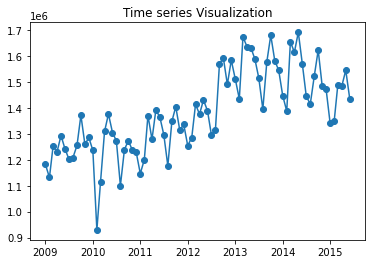

In [73]:
plt.scatter(x = fare_with_time.index,y = fare_with_time.fare_amount)
plt.plot(fare_with_time.index,fare_with_time.fare_amount)
plt.title("Time series Visualization")

In [95]:
def plot_line(x,y,color,name) :
    tracer = go.Scatter(x = x,y = y,mode = "lines",marker = dict(color = color,line = dict(width =1)),name = name)
    return tracer

def plot_layout(title) :
    layout = go.Layout(dict(title = title))
    return layout

def plot_moving_average(ts) :
    #rolling mean and standard deviation
    rolling_mean = ts["fare_amount"].rolling(window = 12,center = False).mean()
    rolling_std  = ts["fare_amount"].rolling(window = 12,center = False).std()
    #plotting
    plt.scatter(ts.index,ts["fare_amount"],color="blue")
    plt.plot(ts.index,ts["fare_amount"],color="blue",label = "time_series")
    plt.plot(rolling_mean.index,rolling_mean.values,color = "black",label="rolling_mean")
    plt.plot(rolling_std.index,rolling_std.values,color ="yellow", label ="rolling_std")
    plt.legend()
    plt.show()

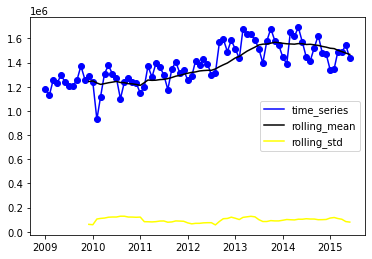

In [96]:
plot_moving_average(fare_with_time)

<b>Checking for stationarity of time series

<b>Augmented Dickey-Fuller(ADF) test

In [86]:
from statsmodels.tsa.stattools import adfuller
def ADF(data):
    test = adfuller(data['fare_amount'])
    result_name = ["ADF Test Statistic","p-value","lags used","no of observations"] 
    result_data = pd.Series(test[:4],index = result_name)
    # result_dict = {}

    for key,value in test[4].items() :
        result_data["Critical value (%s)"%key] = value 

    print (result_data)

ADF(fare_with_time)

ADF Test Statistic      -1.202851
p-value                  0.672368
lags used               12.000000
no of observations      65.000000
Critical value (1%)     -3.535217
Critical value (5%)     -2.907154
Critical value (10%)    -2.591103
dtype: float64


In  the above test:
1. Null Hypothesis(H0): Time series has a unit root , meaning it is non stationary
2. Alternate Hypothesis(H1): Time series does not have a unit root,meaning it is stationary.

Here the test statistics is negative(-1.202851).Hence looking at this alone we are more likely to reject the null hypothesis.
However the test statistics value is larger than the critical values.So we fail to reject the null hypothesis and the time series can be considered non stationary.

<b>Kwiatkowski-Phillip-Schmidt-Shin(KPSS) Test

In [87]:
from statsmodels.tsa.stattools import kpss

kpss_test = kpss(fare_with_time["fare_amount"])

result_name = ["KPSS Test Statistic","p-value","lags used"] 
result_data = pd.Series(kpss_test[:3],index = result_name)
# result_dict = {}

for key,value in kpss_test[3].items() :
    result_data["Critical value (%s)"%key] = value 
print(result_data)

KPSS Test Statistic       0.587993
p-value                   0.023728
lags used                12.000000
Critical value (10%)      0.347000
Critical value (5%)       0.463000
Critical value (2.5%)     0.574000
Critical value (1%)       0.739000
dtype: float64


In the above test:

1. Null Hypothesis(H0): The series is trend stationary
2. Alternate Hypothesis: The series has unit root(series is not stationary)
    
In the output of the test, test statistic 0.588 is lesser than critical value at 1% significance level.
Hence we accept the null hypothesis that the series is trend stationary.

<h3> Eliminating Trend:</h3>

Moving Average can be seen as a method to remove seasonality from the observed time series and to model the trend.So we difference the moving average transformed time series from original time series in log scale to remove the trend.

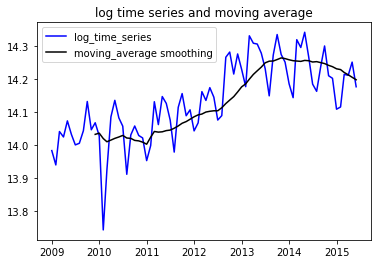

ADF Test Statistic      -1.169879
p-value                  0.686417
lags used               11.000000
no of observations      55.000000
Critical value (1%)     -3.555273
Critical value (5%)     -2.915731
Critical value (10%)    -2.595670
dtype: float64


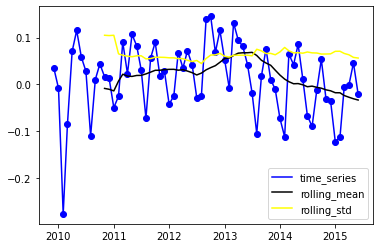

In [97]:
#log of timeseries
log_fare_with_time = np.log(fare_with_time)
#rolling average of log timeseries
rol_avg_log_with_time = log_fare_with_time["fare_amount"].rolling(window = 12,center = False).mean()

#plotting log timeseries and rolling mean
plt.plot(log_fare_with_time.index,log_fare_with_time.fare_amount,color = "blue",label ="log_time_series")
plt.plot(rol_avg_log_with_time.index,rol_avg_log_with_time.values,color ="black",label="moving_average smoothing")
plt.title("log time series and moving average")
plt.legend()
plt.show()

#differencing to remove trend
log_fare_diff_with_time = log_fare_with_time - rol_avg_log_with_time.to_frame()
log_fare_diff_with_time.dropna(inplace = True)
ADF(log_fare_diff_with_time)
plot_moving_average(log_fare_diff_with_time)

Exponential Weighted Moving Average:
    

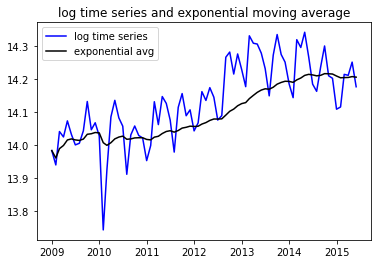

ADF Test Statistic      -1.298039
p-value                  0.630069
lags used               12.000000
no of observations      65.000000
Critical value (1%)     -3.535217
Critical value (5%)     -2.907154
Critical value (10%)    -2.591103
dtype: float64


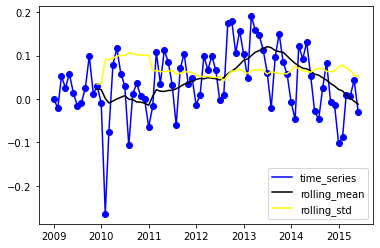

In [99]:
#exponential moving average of log time series
exp_avg_log_ts = log_fare_with_time["fare_amount"].ewm(halflife = 12).mean()

#plotting
plt.plot(log_fare_with_time.index,log_fare_with_time["fare_amount"],color="blue",label = "log time series")
plt.plot(exp_avg_log_ts.index,exp_avg_log_ts.values,color="black",label = "exponential avg")
plt.title("log time series and exponential moving average")
plt.legend()
plt.show()

#difference
exp_diff_time_series = log_fare_with_time - exp_avg_log_ts.to_frame()
ADF(exp_diff_time_series)
plot_moving_average(exp_diff_time_series)

<b> Differencing

ADF Test Statistic     -5.983599e+00
p-value                 1.814072e-07
lags used               1.200000e+01
no of observations      6.300000e+01
Critical value (1%)    -3.538695e+00
Critical value (5%)    -2.908645e+00
Critical value (10%)   -2.591897e+00
dtype: float64


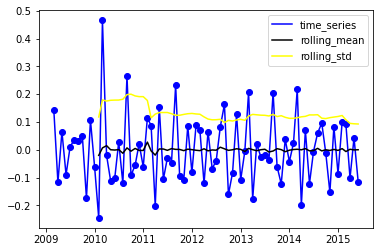

In [100]:
#differencing log series
fare_diff = log_fare_with_time - log_fare_with_time.shift()
fare_diff = fare_diff - fare_diff.shift()
fare_diff.dropna(inplace = True)

# #plotting
# t1 = plot_line(fare_diff.index,fare_diff["fare_amount"],"blue","Differenced of log Time Series")
# layout = plot_layout("Differenced log series")
# fig = go.Figure(data = [t1],layout=layout)
# py.iplot(fig)

#stationary test
ADF(fare_diff)
plot_moving_average(fare_diff)

<h2> Decomposition </h2>

Time Series can be broken  down into Systematic(Can be Described and Modeled) and Non Systematic(cannot be directly modelled) as follows:<br>

1. Level : the average value in the series
2. Trend : The increasing or decreasing values in the series
3. Seasonality: The recurring short-term cycle in the series.
4. Noise: The random Variation in the series.

A time series can be thought of as an 'Additive' and/or 'Multiplicative' construction of these four components.<br>

Decomposition is a statistical task that deconstructs a time series into its components mentioned above.Its provides a structured way of thinking about a time series forecasting  problem,both in terms of modelling complexity and specifically in terms of how to best capture each of these components in a given model.<br>

The statsmodels library of python provides an implementation of the naive or classical decomposition method in the function ``seasonal_decompose()``.<br>
However, sometimes this naive models are not able to separate the noise in the time series.In such casee we can use more advanced decompostion techniques like ``Loess or STL decompostion``


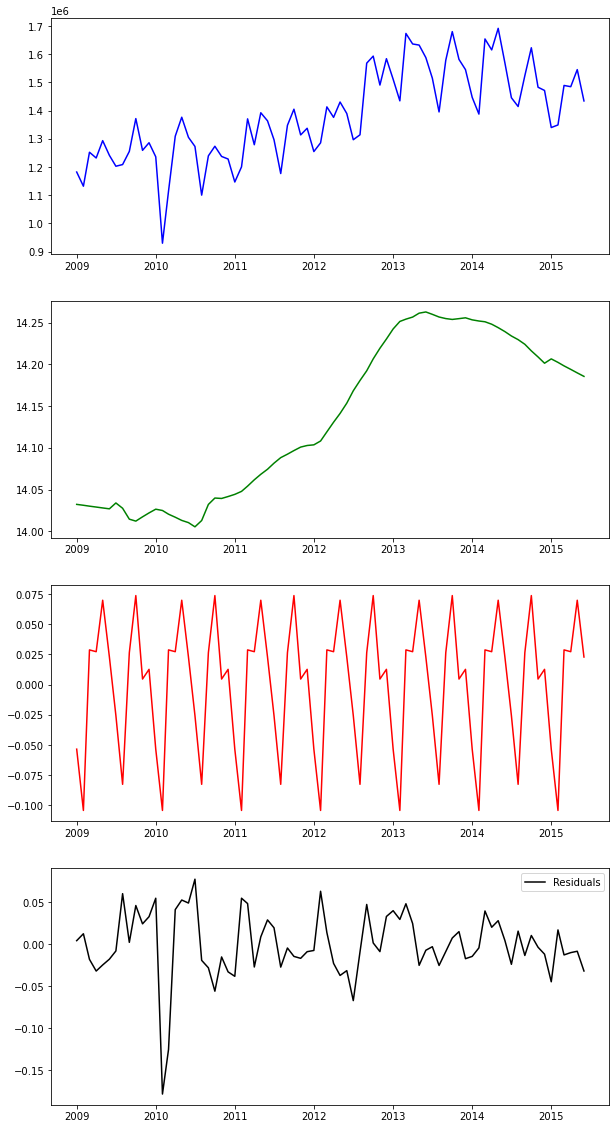

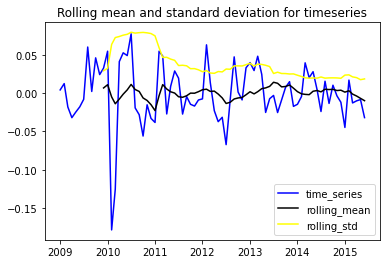

In [103]:
from statsmodels.tsa.seasonal import seasonal_decompose

#decompose
result = seasonal_decompose(log_fare_with_time,freq=12, extrapolate_trend='freq')

#trend
trend  = result.trend
#seasonality
seasonality = result.seasonal
#residuals
residuals   = result.resid

f, ax = plt.subplots(4,1,figsize=(10,20))
#plotting
ax[0].plot(fare_with_time.index,fare_with_time.fare_amount,color = "blue",label = "log_Series")
ax[1].plot(trend.index,trend.values,color = "green",label = "Trend")
ax[2].plot(seasonality.index,seasonality.values,color = "red",label = "Seasonality")
ax[3].plot(residuals.index,residuals.values,color = "black",label = "Residuals")
plt.legend()
plt.show()


#stationary test for residuals
residuals.dropna(inplace = True)

#Plotting Stationary Residuals
rolling_mean = residuals.rolling(window = 12,center = False).mean()
rolling_std  = residuals.rolling(window = 12,center = False).std()
#plotting
plt.plot(residuals.index,residuals.values,color = "blue",label = "time_series")
plt.plot(rolling_mean.index,rolling_mean.values,color = "black",label = "rolling_mean")
plt.plot(rolling_std.index,rolling_std.values,color = "yellow",label = "rolling_std")
plt.title("Rolling mean and standard deviation for timeseries")
plt.legend()
plt.show()

Above, we are plotting the residuals of the time series after removing `trend` and `seasonality`.

<h2> Classical linear Time Series Forecasting Methods: </h2>

In [104]:
from statsmodels.tsa.arima_model import ARIMA

def model(ts,p,d,q,plot = True) :
    model   = ARIMA(ts , order = (p,d,q))
    results = model.fit(disp = -1)
    fits = results.fittedvalues
    if(plot == True):
        t1 = plot_line(fits.index,fits.values,"blue","fit value")
        t2 = plot_line(fare_diff.index,fare_diff["fare_amount"],"black","difference of log values")
        layout = plot_layout(("ARIMA model p = " + str(p) + ", d = " + str(d) + ", q = " + str(q)))
        data  = [t2,t1]
        fig   = go.Figure(data = data,layout = layout)
        py.iplot(fig)
        print(results.summary())
        print("**********************")

        print("Plot of Residuals")
        residuals = pd.DataFrame(results.resid)
        residuals.plot()
        plt.show()

        print("Density of the residuals")
        residuals.plot(kind = 'kde')
        pyplot.show()

        print(residuals.describe())
        
    else:
        return results,fits
    

def predict(ts,p,d,q):
    size = int(len(ts.values)*0.8)
    train, test = ts.values[0:size],ts.values[size:len(ts)]
    history = [i for i in train]
    pred = []
    for t in range(len(test)):
        model_fit,_ = model(history,p,d,q,False)
        output = model_fit.forecast()
        y_hat = output[0]
        pred.append(y_hat)
        observed = test[t]
        history.append(observed)
        print('predicted = {} and expected = {}'.format(y_hat,observed))
        
    error = mse(test,pred)
    print("Test MSE = ", error)
    plt.plot(test,color='red')
    plt.plot(pred,color='blue')

<h3> 1. AutoRegression Model(AR):</h3>

The Autoregression method models the next step in the sequence as a linear function of the observations at the prior steps.The order for this model can be specified in the 'p' parameter of the ARIMA model.<br>

We are applying the difference sequence of the log fare-amount data to the ARIMA model.

                              ARMA Model Results                              
Dep. Variable:            fare_amount   No. Observations:                   76
Model:                     ARMA(4, 0)   Log Likelihood                  73.615
Method:                       css-mle   S.D. of innovations              0.091
Date:                Mon, 28 Sep 2020   AIC                           -135.230
Time:                        15:09:14   BIC                           -121.246
Sample:                    03-01-2009   HQIC                          -129.641
                         - 06-01-2015                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0001      0.003     -0.033      0.974      -0.006       0.006
ar.L1.fare_amount    -0.7570      0.105     -7.204      0.000      -0.963      -0.551
ar.L2.fare_amount    -0.

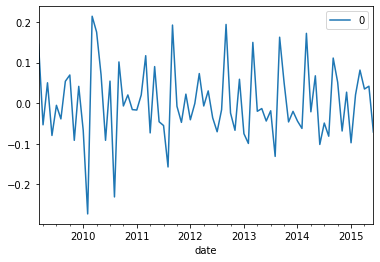

Density of the residuals


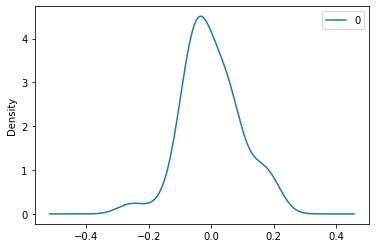

               0
count  76.000000
mean    0.001004
std     0.092485
min    -0.273124
25%    -0.057012
50%    -0.014658
75%     0.054051
max     0.214273


In [105]:
model(fare_diff,4,0,0)

predicted = [0.03852292] and expected = [0.21776971]
predicted = [-0.17962945] and expected = [-0.19957329]
predicted = [-0.00717627] and expected = [0.07002789]
predicted = [-0.00435784] and expected = [-0.12156174]
predicted = [0.04793324] and expected = [-0.00669574]
predicted = [0.14224808] and expected = [0.06021501]
predicted = [-0.01843325] and expected = [0.09614963]
predicted = [-0.06898516] and expected = [-0.01124925]
predicted = [-0.08364981] and expected = [-0.15339962]
predicted = [0.05715587] and expected = [0.08253723]
predicted = [0.0167092] and expected = [-0.08593015]
predicted = [0.0768787] and expected = [0.10046571]
predicted = [0.00593956] and expected = [0.09208969]
predicted = [-0.13782634] and expected = [-0.10182382]
predicted = [0.00046685] and expected = [0.04294843]
predicted = [-0.04026329] and expected = [-0.114689]
Test MSE =  0.0069414471513004426


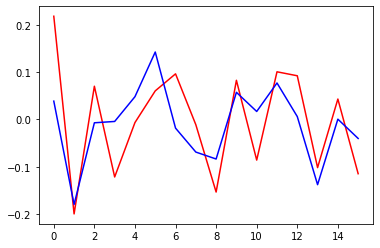

In [106]:
predict(fare_diff,4,0,0)

<h3>2. Moving Average (MA) model</h3>

                              ARMA Model Results                              
Dep. Variable:            fare_amount   No. Observations:                   76
Model:                     ARMA(0, 4)   Log Likelihood                  91.260
Method:                       css-mle   S.D. of innovations              0.070
Date:                Mon, 28 Sep 2020   AIC                           -170.520
Time:                        15:09:19   BIC                           -156.535
Sample:                    03-01-2009   HQIC                          -164.931
                         - 06-01-2015                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0001      0.000     -0.336      0.737      -0.001       0.001
ma.L1.fare_amount    -1.4009      0.120    -11.673      0.000      -1.636      -1.166
ma.L2.fare_amount    -0.

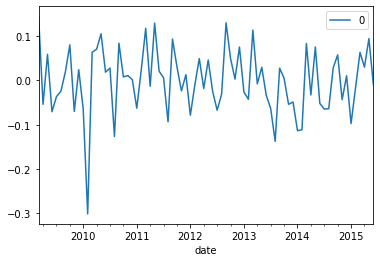

Density of the residuals


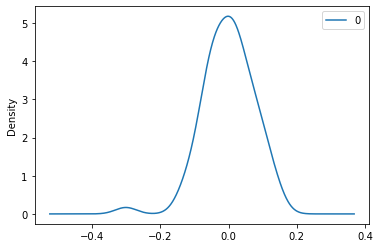

               0
count  76.000000
mean   -0.000808
std     0.073879
min    -0.301230
25%    -0.049344
50%     0.004001
75%     0.049486
max     0.144931


In [107]:
model(fare_diff,0,0,4)

predicted = [0.1246052] and expected = [0.21776971]
predicted = [-0.14148742] and expected = [-0.19957329]
predicted = [0.0287509] and expected = [0.07002789]
predicted = [-0.02847279] and expected = [-0.12156174]
predicted = [0.10987676] and expected = [-0.00669574]
predicted = [0.12317584] and expected = [0.06021501]
predicted = [0.06205502] and expected = [0.09614963]
predicted = [-0.0758594] and expected = [-0.01124925]
predicted = [-0.11260198] and expected = [-0.15339962]
predicted = [0.06401092] and expected = [0.08253723]
predicted = [0.00304644] and expected = [-0.08593015]
predicted = [0.10944196] and expected = [0.10046571]
predicted = [0.0155201] and expected = [0.09208969]
predicted = [-0.14739433] and expected = [-0.10182382]
predicted = [-0.06128812] and expected = [0.04294843]
predicted = [-0.10292979] and expected = [-0.114689]
Test MSE =  0.004641328109003899


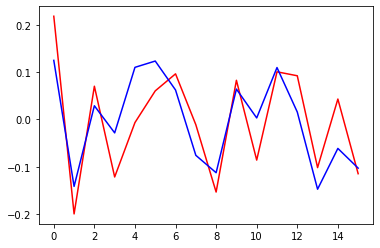

In [108]:
predict(fare_diff,0,0,4)

<h3>4 . AutoRegressive Integrated Moving Average(ARIMA)</h3>

                             ARIMA Model Results                              
Dep. Variable:          D.fare_amount   No. Observations:                   77
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  99.195
Method:                       css-mle   S.D. of innovations              0.066
Date:                Mon, 28 Sep 2020   AIC                           -186.389
Time:                        15:09:33   BIC                           -172.326
Sample:                    02-01-2009   HQIC                          -180.764
                         - 06-01-2015                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0024      0.002      0.996      0.319      -0.002       0.007
ar.L1.D.fare_amount     0.8823      0.156      5.661      0.000       0.577       1.188
ar.L2.D.fare_amo

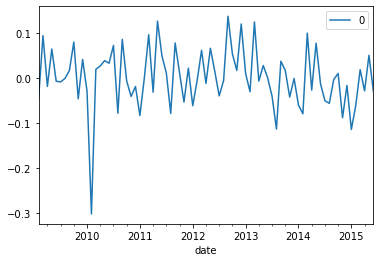

Density of the residuals


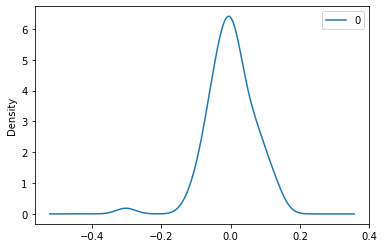

               0
count  77.000000
mean    0.000569
std     0.067001
min    -0.302150
25%    -0.040039
50%    -0.001387
75%     0.038255
max     0.136757


In [110]:
model(log_fare_with_time,2,1,2)

predicted = [14.22623339] and expected = [14.31904485]
predicted = [14.33041713] and expected = [14.29527865]
predicted = [14.27163371] and expected = [14.34154035]
predicted = [14.28792137] and expected = [14.26624031]
predicted = [14.24410544] and expected = [14.18424454]
predicted = [14.22593519] and expected = [14.16246378]
predicted = [14.24507824] and expected = [14.23683264]
predicted = [14.29519114] and expected = [14.29995226]
predicted = [14.305488] and expected = [14.20967226]
predicted = [14.22913904] and expected = [14.20192949]
predicted = [14.23203807] and expected = [14.10825658]
predicted = [14.18076223] and expected = [14.11504938]
predicted = [14.19422551] and expected = [14.21393186]
predicted = [14.24079804] and expected = [14.21099053]
predicted = [14.19934077] and expected = [14.25099763]
predicted = [14.20792264] and expected = [14.17631573]
Test MSE =  0.003588349965546592


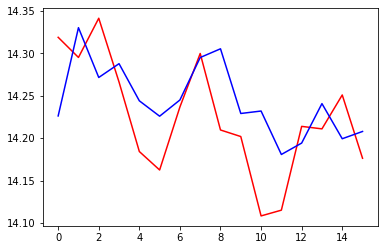

In [111]:
predict(log_fare_with_time,2,1,2)